In [24]:
# install important libraires

In [25]:
!pip install ultralytics
!pip install roboflow
!pip install easyocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [26]:
# import libraries

In [27]:
import cv2
from ultralytics import YOLO
from google.colab import drive
from google.colab.patches import cv2_imshow
from roboflow import Roboflow
import easyocr
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
reader = easyocr.Reader(['en'])

In [29]:
# Downloading the dataset

In [30]:
rf = Roboflow(api_key="NjpEWR9kdbfZvnCzLdGZ")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8-obb")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
#Train the Model

In [ ]:
model = YOLO('yolov8l.pt')
results = model.train(data='/content/data.yaml', epochs=100, imgsz=640)

In [31]:
class ImageProcessor:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.reader = easyocr.Reader(['en'], gpu=False)  # Adjust GPU based on your setup

    def load_and_predict(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Image not found at the provided path.")
        return self.model.predict(image)

    def annotate_and_crop(self, image, results, display=False, save_crops=False):
        cropped_images = []
        if results:
            for result in results:
                boxes = result.boxes.data
                for i, box in enumerate(boxes):
                    x1, y1, x2, y2 = box[:4].int().tolist()
                    crop_img = image[y1:y2, x1:x2].copy()
                    cropped_images.append(crop_img)
                    cv2.rectangle(crop_img, (0, 0), (x2-x1, y2-y1), (0, 255, 0), 2)
                    if save_crops:
                        cv2.imwrite(f'crop_{i}.jpg', crop_img)
                    if display:
                        cv2_imshow(crop_img)
        else:
            print("No detection results to display.")
        return cropped_images

    def extract_text(self, images):
        extracted_texts = []
        for image in images:
            results = self.reader.readtext(image)
            text = ' '.join([result[1] for result in results])
            extracted_texts.append(text.strip())
        return extracted_texts


0: 640x640 1 License_Plate, 568.9ms
Speed: 3.1ms preprocess, 568.9ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)


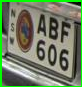

AbF 606


In [32]:
processor = ImageProcessor('/content/drive/MyDrive/Licence_Plate_Model.pt')
image_path = '/content/License-Plate-Recognition-4/test/images/002901d9d194c4fb_jpg.rf.292313a88fa94fe76a51739acc95b5ab.jpg'
results = processor.load_and_predict(image_path)
image_path = cv2.imread(image_path)
cropped_images = processor.annotate_and_crop(image_path, results, display=True, save_crops=True)
extracted_texts = processor.extract_text(cropped_images)
for text in extracted_texts:
    print(text)